<h1>Análise dos dados gerados em <strong> dataBase.gen.csv </strong> </h1>

<h2>
A base de dados escolhida consiste em um conjunto de dados que descrevem a rotina de compra de um ecommerce. Nela podemos visualizar diversas características de um produto, como o nome, preço, descrição, nota atribuída, comentários, local de compra, etc.

Por ser tão abrangente, essa análise será limitada ao sistema de avaliação feito pelos clientes após a confirmação de entrega do produto. Assim, o consumidor pode dar nota de 1 a 5 para o produto, sendo 1 o mais baixo e 5 o mais alto. Os comentários avaliativos serão desconsiderados para essa primeira proposta.

Com essas avaliações, a plataforma de e-commerce consegue tirar insights sobre a qualidade do produto. Com essas avaliações, consegue-se trazer melhorias para o negócio. A grande questão que surge é: Seria possível prever a pontuação dos clientes com base em alguma outra métrica antes mesmo dessa avaliação ser efetuada? Caso sim, também seria possível prever os casos sem avaliação. No estudo em questão, o principal objetivo é resolver esse problema, que é a previsão da satisfação do cliente para que o comércio eletrônico possa lançar mão de meios para mitigar eventuais danos em determinados casos. </h2>

<!-- Alguns requisitos que devem ser observados são:

1) Classificações baixas (1,2 e 3) são essenciais para a melhoria do negocio e devem ser analisada e classificadas corretamente;
2) O modelo não deve demorar muito para ser executado e fazer as previsões, já que essa previsão deve ser feita antes que o usuário dê a nota. -->


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import abspath

# lendo dados
data = pd.read_csv(abspath('./data/dataBase.gen.csv'))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94656 entries, 0 to 94655
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       94656 non-null  object 
 1   payment_sequential             94656 non-null  int64  
 2   payment_type                   94656 non-null  object 
 3   payment_installments           94656 non-null  int64  
 4   payment_value                  94656 non-null  float64
 5   customer_id                    94656 non-null  object 
 6   order_status                   94656 non-null  object 
 7   order_purchase_timestamp       94656 non-null  object 
 8   order_approved_at              94656 non-null  object 
 9   order_delivered_carrier_date   94656 non-null  object 
 10  order_delivered_customer_date  94656 non-null  object 
 11  order_estimated_delivery_date  94656 non-null  object 
 12  review_score                   94656 non-null 

<h2>Checando a distribuição de notas dadas pelos clientes</h2>


Total:
  5    55790
4    18576
1     9476
3     7875
2     2939
Name: review_score, dtype: int64
************************************************************
Porcentagem da distribuição:
  5    58.939740
4    19.624746
1    10.010987
3     8.319599
2     3.104927
Name: review_score, dtype: float64
************************************************************


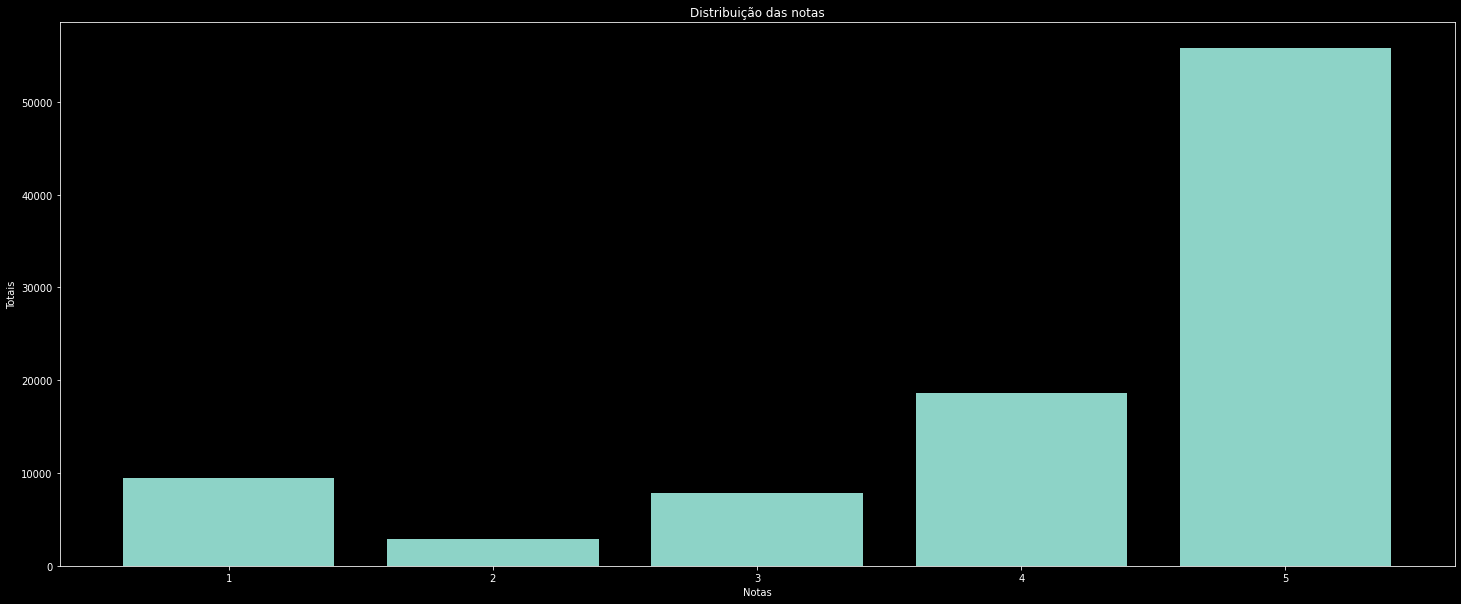

In [44]:
print("Total:\n ", data["review_score"].value_counts())
print("**"*30)
print("Porcentagem da distribuição:\n ", 100 *
      data["review_score"].value_counts(normalize=True))
print("**"*30)

plt.style.use('dark_background')
plt.figure(figsize = (25,10))
base_color = sns.color_palette()[0]

plt.bar(data["review_score"].value_counts().index,
        data["review_score"].value_counts(), color=base_color)

plt.xlabel("Notas")
plt.ylabel("Totais")
plt.title("Distribuição das notas")
plt.show()


https://academic.oup.com/forestscience/article-abstract/11/4/405/4746324?redirectedFrom=PDF

<h2>É possível perceber que essa distribuição é dada em forma de <strong>J</strong> e é bastante típica em ecommerces. Grande quantidade de avaliações 5, 4 e 1, pequena quantidade de 2 e 3. </h2>


<h2>Fazendo correlações entre todas as colunas, formamos uma matriz de calor onde quanto mais próximo de 1 (ou -1), maior a correlação de pearson da variável</h2>


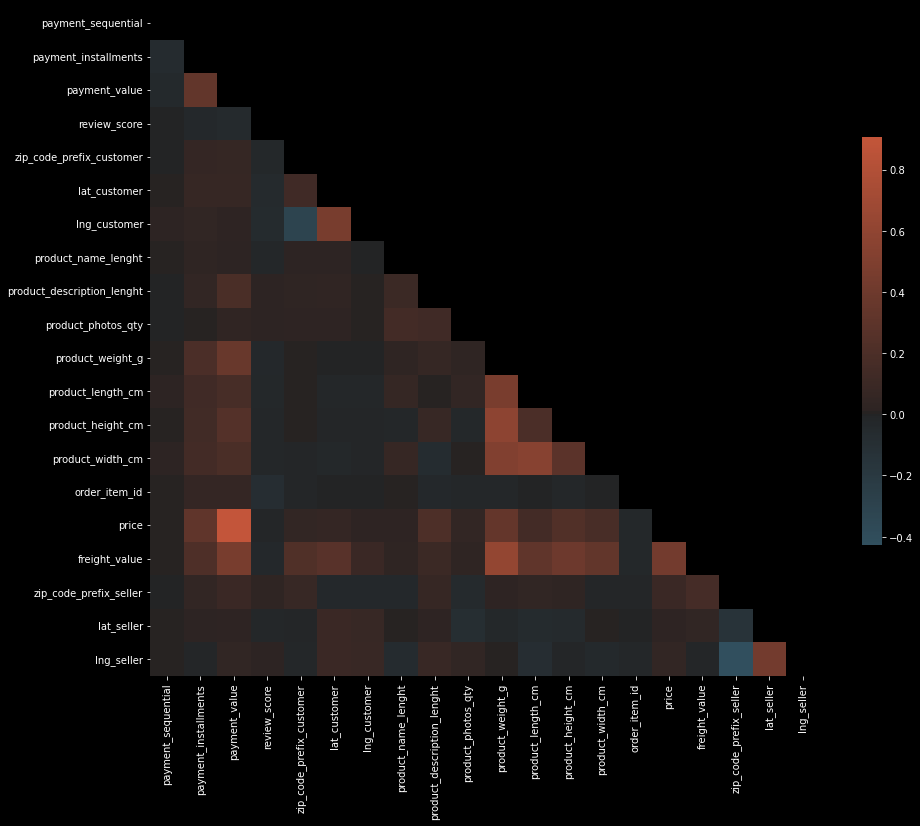

In [45]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

correlation = data.corr()

mask = np.triu(np.ones_like(correlation, dtype='bool'))
f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True, center="dark")

sns.heatmap(correlation, mask=mask, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .5})
plt.show()


<h2>Visualizando algumas correlações interessantes, como por ex:</h2>
<ul> 
<li>Uma relação mais forte entre pesos e medidas dos produtos e o valor de frete</li>
<li>Uma relação forte entre pesos e medidas com o preço do produto</li>
</ul>


In [64]:
data.corr()["review_score"]

payment_sequential           -0.000967
payment_installments         -0.030959
payment_value                -0.042594
review_score                  1.000000
zip_code_prefix_customer     -0.021838
lat_customer                 -0.043827
lng_customer                 -0.052041
product_name_lenght          -0.016235
product_description_lenght    0.013123
product_photos_qty            0.014171
product_weight_g             -0.030121
product_length_cm            -0.021433
product_height_cm            -0.018459
product_width_cm             -0.014284
order_item_id                -0.082465
price                        -0.006672
freight_value                -0.035158
zip_code_prefix_seller        0.024167
lat_seller                   -0.010733
lng_seller                    0.015057
Name: review_score, dtype: float64

<h2>Para as notas dadas pelo cliente, vemos baixíssimas correlações, inclusive do preço e do frete.</h2>


<h2> Agora tentemos outra abordagem e partamos para analisar a relação do tipo do pagamento com a nota de review. Essa correlação não é explicita no mapa, já que o tipo de pagamento é uma variável categórica, e não um numérica. </h2>


In [68]:
pay_type_score = data.groupby("review_score")[
    "payment_type"].value_counts(normalize=True)
pay_type_score.unstack()


payment_type,boleto,credit_card,debit_card,voucher
review_score,,,,
1,0.194386,0.764880,0.012664,0.028071
2,0.196666,0.755359,0.015311,0.032664
3,0.207365,0.749968,0.014349,0.028317
4,0.202089,0.758452,0.014912,0.024548
5,0.197742,0.759455,0.016114,0.026689


<h2>Ou graficamente</h2>


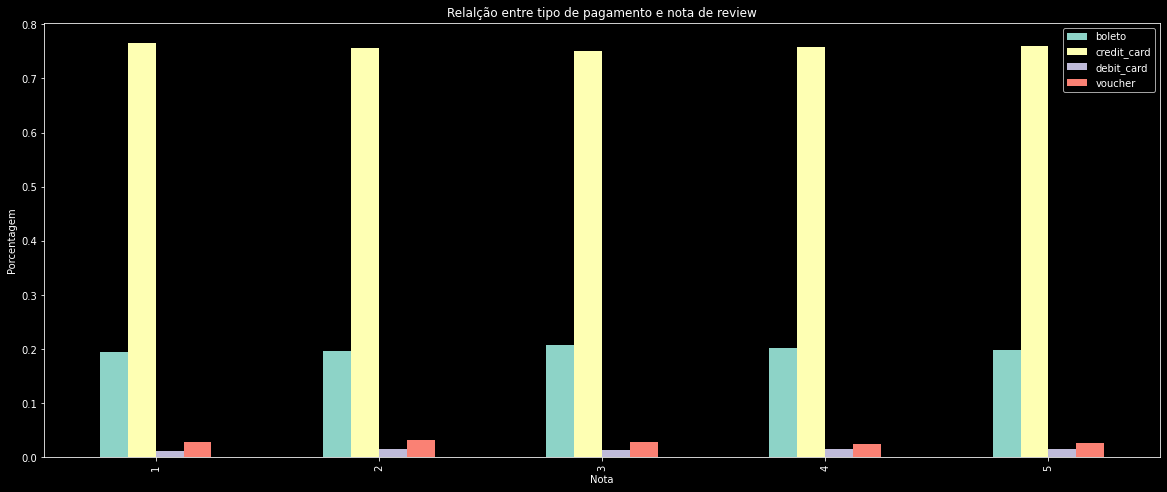

In [71]:
pay_type_score.unstack().plot.bar(figsize=(20, 8)).legend(loc="best")
plt.ylabel("Porcentagem")
plt.xlabel("Nota")
plt.title("Relalção entre tipo de pagamento e nota de review")
plt.show()


<h2>Vemos que a distribuição não muda conforme a nota avaliativa. Logo, lançaremos mão de um teste estatístico não paramétrico chi-quadrado com nível de significância alfa=0,05 para avaliar a independência dessas duas variáveis de teste </h2>
</p>
<h2>As hipóteses de teste são:
<ul>
<li>Hipótese nula: A correlação entre o tipo de pagamento e a nota de review é nula</li>
<li>Hipótese alternativa: A correlação entre o tipo de pagamento e a nota de review é positiva</li>
</ul>
</h2>


In [73]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html
from scipy.stats import chi2_contingency, chi2

# Tabela de contingência
table = pd.crosstab(data["payment_type"], data["review_score"], margins=False)

chi_2, p_value, dof, expected = chi2_contingency(table)

alpha = 0.05
print("Nível de significância: ", alpha)
print("p-valor: ", p_value)

if p_value < alpha:
    print("Rejeita hipótese nula")
else:
    print("Não rejeita hipótese nula")
print("*"*30)

prob = 1 - alpha
critical = chi2.ppf(prob, dof)

print("O valor crítico: ", critical)
print("Chi2: ", chi_2)

if chi_2 >= critical:
    print("Rejeita hipótese nula")
else:
    print("Não rejeita hipótese nula")


Nível de significância:  0.05
p-valor:  0.0329763822015305
Rejeita hipótese nula
******************************
O valor crítico:  21.02606981748307
Chi2:  22.42973961500558
Rejeita hipótese nula


<h2>Subdividinto as notas de 1 a 5, temos:</h2>


In [52]:
rate_1 = data[data["review_score"] == 1]
rate_2 = data[data["review_score"] == 2]
rate_3 = data[data["review_score"] == 3]
rate_4 = data[data["review_score"] == 4]
rate_5 = data[data["review_score"] == 5]


In [58]:
data[(data["payment_type"] != "voucher") & (data["payment_sequential"] > 3)]


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_item_id,seller_id,shipping_limit_date,price,freight_value,zip_code_prefix_seller,lat_seller,lng_seller,seller_city,seller_state


In [61]:
data[(data["payment_sequential"] > 3) & (data["payment_installments"] > 1)]


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_item_id,seller_id,shipping_limit_date,price,freight_value,zip_code_prefix_seller,lat_seller,lng_seller,seller_city,seller_state


In [62]:
data[(data["payment_type"] == "voucher") & (data["payment_installments"] > 1)]


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_item_id,seller_id,shipping_limit_date,price,freight_value,zip_code_prefix_seller,lat_seller,lng_seller,seller_city,seller_state
